<a href="https://colab.research.google.com/github/johnmichaelt/cmsc_191_paper_neural_network/blob/main/Obesity_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas
import tensorflow
import seaborn
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.metrics import CategoricalAccuracy, Precision, Recall, AUC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

# FILE READING AND FORMATTING
dataframe = pandas.read_csv("/content/ObesityDataSet_raw_and_data_sinthetic.csv", header=0)
dataframe = dataframe.dropna()

# TRANSFORM CLASS INPUT (TRANSPORTATION) INTO CLASSIFICATION COLUMNS
dummy_transportation = pandas.get_dummies(dataframe['MTRANS'],  drop_first=True)
dataframe = pandas.concat([dataframe, dummy_transportation], axis=1)
dataframe.drop('MTRANS', axis=1, inplace=True)
dataframe = dataframe[[c for c in dataframe if c not in ['NObeyesdad']] + [c for c in ['NObeyesdad'] if c in dataframe]]
dataframe = dataframe.sort_values(['NObeyesdad'])




In [5]:
# DATAFRAME -> NUMPY.NDARRAY
dataset = dataframe.values
group_segments = []
group_label = []
group_index = []
group_count = 0
string_segment = dataset[0][19]

# MULTICLASS COUNT & MULTICLASS LABEL COLLECTION
for item_index in range(len(dataset)):
  group_count += 1
  if dataset[item_index][19] == string_segment:
    continue
  else:
    group_label.append(string_segment)
    string_segment = dataset[item_index][19]
    group_segments.append(group_count)
    group_index.append(item_index)
    group_count = 0
group_index.append(len(dataset) - 1)
group_label.append(string_segment)
group_segments.append(group_count)

# IDENTIFICATION OF TRAINING-VALIDATION-TESTING (TVT) SET SIZES PER CLASS
training_count = [int(x) for x in (list(np.around([count * 0.6 for count in group_segments])))]
validation_count = [int(x) for x in (list(np.around([count * 0.2 for count in group_segments])))]
testing_count = [group_segments[x] - training_count[x] - validation_count[x] for x in range(len(group_segments))]

# INITIALIZE SETS (COLLECTIVE)
training_set = np.empty([1,20])
validation_set = np.empty([1,20])
testing_set = np.empty([1,20])




In [6]:
# DATASET SEPARATION PER CLASS FOR STRATIFIED SAMPLING
insufficient_group = dataset[0:273, :]
normal_group = dataset[273:560, :]
obesity_i_group = dataset[560:911, :]
obesity_ii_group = dataset[911:1208, :]
obesity_iii_group = dataset[1208:1532, :]
overweight_i_group = dataset[1532:1822, :]
overweight_ii_group = dataset[1822:2111, :]

# SHUFFLE CLASS, GET TVT SCALING PER CLASS, BUILD COLLECTIVE SET
def shuffle_list(list_group, category):
  for item in range(5):
    np.random.shuffle(list_group)
  validation_testing_boundary = training_count[category] + validation_count[category]
  testing_boundary = validation_testing_boundary + testing_count[category]
  training_list = list_group[0:training_count[category]]
  validation_list = list_group[training_count[category]:validation_testing_boundary]
  testing_list = list_group[validation_testing_boundary:testing_boundary]
  global training_set
  global validation_set
  global testing_set
  training_set = np.concatenate((training_set, training_list), axis=0)
  validation_set = np.concatenate((validation_set, validation_list), axis=0)
  testing_set = np.concatenate((testing_set, testing_list), axis=0)

shuffle_list(insufficient_group, 0)
shuffle_list(normal_group, 1)
shuffle_list(obesity_i_group, 2)
shuffle_list(obesity_ii_group, 3)
shuffle_list(obesity_iii_group, 4)
shuffle_list(overweight_i_group, 5)
shuffle_list(overweight_ii_group, 6)

# REMOVE GARBAGE VALUE FROM INITIALIZATION
training_set = np.delete(training_set, 0, 0)
validation_set = np.delete(validation_set, 0, 0)
testing_set = np.delete(testing_set, 0, 0)




In [7]:
# ASSEMBLE SEPARATED SETS FOR TRANSFORMATION
entire_dataset = np.concatenate((training_set, validation_set, testing_set), axis=0)

# NON-QUANTITATIVE DATA TRANSFORMATION TO QUANTITATIVE FORMAT (EXCEPT OBESITY CLASSIFICATION COLUMN)
for item in entire_dataset:
  for dataIndex in range(len(item)):
    if (dataIndex == 0 and item[dataIndex] == "Female") or item[dataIndex] == "yes" or ((dataIndex == 8 or dataIndex == 14) and item[dataIndex] == "Sometimes"):
      item[dataIndex] = 1
    elif ((dataIndex == 8 or dataIndex == 14) and item[dataIndex] == "Frequently"):
      item[dataIndex] = 2
    elif ((dataIndex == 8 or dataIndex == 14) and item[dataIndex] == "Always"):
      item[dataIndex] = 3
    elif item[dataIndex] == "no" or (dataIndex == 0 and item[dataIndex] == "Male"):
      item[dataIndex] = 0

training_count_total = sum(training_count)
validation_count_total = sum(validation_count)
testing_count_total = sum(testing_count)

# SPLIT ASSEMBLED MODIFIED SET TO TVT SETS
Train_set_random = entire_dataset[0:training_count_total,:]
Validation_set_random = entire_dataset[training_count_total:training_count_total + validation_count_total, :]
Test_set_random = entire_dataset[training_count_total + validation_count_total:, :]

# SHUFFLE TVT SETS
np.random.shuffle(Train_set_random)
np.random.shuffle(Validation_set_random)
np.random.shuffle(Test_set_random)

# X AND Y DATA ISOLATION FOR EACH SET IN TVT SETS
X_train = Train_set_random[:,0:19].astype('float32')
Y_train = Train_set_random[:,19]
X_validation = Validation_set_random[:,0:19].astype('float32')
Y_validation = Validation_set_random[:,19]
X_test = Test_set_random[:, 0:19].astype('float32')
Y_test = Test_set_random[:,19]

# DATA SCALING FOR EASIER DATA MANAGEMENT
scaler = StandardScaler()
# scaler = Normalizer()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

# Y DATA COLUMN TRANSFORMATION TO CATEGORICAL MANAGEABLE DATA
encoder = LabelEncoder()
encoder.fit(Y_train)
encoded_Y_train = encoder.transform(Y_train)
encoded_Y_validation = encoder.transform(Y_validation)
encoded_Y_test = encoder.transform(Y_test)

dummy_Y_train = np_utils.to_categorical(encoded_Y_train)
dummy_Y_validation = np_utils.to_categorical(encoded_Y_validation)
dummy_Y_test = np_utils.to_categorical(encoded_Y_test)




In [20]:
# MODEL CONSTRUCTION
BATCH_SIZE = 20
EPOCHS = 25

stop_model_learning = tensorflow.keras.callbacks.EarlyStopping(monitor="val_loss", verbose=0, mode="min", patience=10, restore_best_weights=True)

def main_model():
  model = Sequential()
  initializer = tensorflow.keras.initializers.RandomNormal(mean=0., stddev=1.)
  model.add(Dense(19, input_dim=19, activation='relu'))
  model.add(Dense(15, activation='relu'))
  model.add(Dense(11, activation='relu'))
  model.add(Dense(7, activation='softmax', bias_initializer=initializer))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[
    CategoricalAccuracy(name = 'accuracy'),
    Precision(name = 'precision'),
    Recall(name = 'recall'),
    AUC(name = 'aucroc', curve = 'ROC')
  ])
  return model

# INITIALIZATION OF MODEL
initial_model = main_model()
initial_model.save_weights('start_weights.model')

# FINAL MODEL TRAINING
obesity_model = main_model()
obesity_model.load_weights('start_weights.model')
records = obesity_model.fit(X_train, dummy_Y_train, verbose=1, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data=(X_validation, dummy_Y_validation))




Epoch 1/25
64/64 [==============================] - 2s 11ms/step - loss: 2.2222 - accuracy: 0.1919 - precision: 0.2711 - recall: 0.0355 - aucroc: 0.5524 - val_loss: 1.9729 - val_accuracy: 0.2915 - val_precision: 0.0769 - val_recall: 0.0024 - val_aucroc: 0.6074
Epoch 2/25
64/64 [==============================] - 0s 4ms/step - loss: 1.7399 - accuracy: 0.3942 - precision: 0.5000 - recall: 0.0197 - aucroc: 0.6918 - val_loss: 1.5550 - val_accuracy: 0.4028 - val_precision: 0.7317 - val_recall: 0.0711 - val_aucroc: 0.7859
Epoch 3/25
64/64 [==============================] - 0s 3ms/step - loss: 1.4302 - accuracy: 0.4700 - precision: 0.7536 - recall: 0.1667 - aucroc: 0.8286 - val_loss: 1.3533 - val_accuracy: 0.4645 - val_precision: 0.7241 - val_recall: 0.2488 - val_aucroc: 0.8531
Epoch 4/25
64/64 [==============================] - 0s 3ms/step - loss: 1.2418 - accuracy: 0.5087 - precision: 0.8038 - recall: 0.2654 - aucroc: 0.8814 - val_loss: 1.2003 - val_accuracy: 0.5047 - val_precision: 0.7843 -

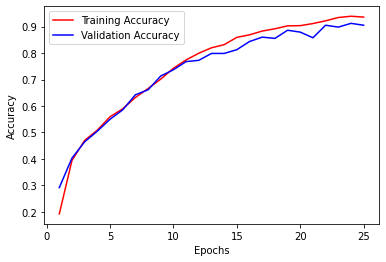

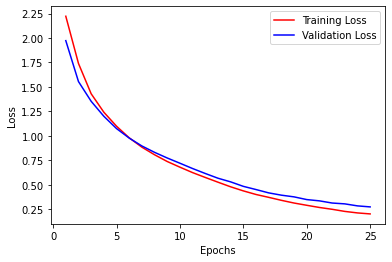

In [21]:
# TRAINING STATISTICS/GRAPH: ACCURACY
print("\n")
accuracy_train = records.history['accuracy']
accuracy_validation = records.history['val_accuracy']
plt.plot(range(1,EPOCHS + 1), accuracy_train, 'r', label="Training Accuracy")
plt.plot(range(1,EPOCHS + 1), accuracy_validation, 'b', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
print("\n")

# TRAINING STATISTICS/GRAPH: LOSS
loss_train = records.history['loss']
loss_validation = records.history['val_loss']
plt.plot(range(1,EPOCHS + 1), loss_train, 'r', label="Training Loss")
plt.plot(range(1,EPOCHS + 1), loss_validation, 'b', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
print("\n")

# MODEL PREDICTION FOR A GIVEN SET
# WITH MODEL STATISTICS
def predict_model(X_variable, Y_variable):
  model_prediction_test = obesity_model.predict(X_variable)
  model_statistics = obesity_model.evaluate(X_variable, Y_variable, batch_size = BATCH_SIZE)
  for item in range(len(model_statistics)):
    print(obesity_model.metrics_names[item], ": ", model_statistics[item])
  model_matrix = confusion_matrix(Y_variable.argmax(1), model_prediction_test.argmax(1))
  print(classification_report(Y_variable.argmax(1), model_prediction_test.argmax(1), digits = 3))
  show_confusion_matrix_diagram(model_matrix)

# CONFUSION MATRIX VISUALIZATION OF A GIVEN SET
def show_confusion_matrix_diagram(confusion_matrix):
  frame_matrix = pandas.DataFrame(confusion_matrix, index = group_label, columns = group_label)
  plt.figure(figsize = (8,5))
  seaborn.heatmap(frame_matrix, annot=True, fmt="d", cmap="YlGnBu")
  plt.xlabel('Predicted Level')
  plt.ylabel('Actual Level')




64/64 [==============================] - 0s 2ms/step - loss: 0.1842 - accuracy: 0.9471 - precision: 0.9564 - recall: 0.9360 - aucroc: 0.9983
loss :  0.1841956079006195
accuracy :  0.9470773935317993
precision :  0.9564164876937866
recall :  0.9360189437866211
aucroc :  0.9983401298522949
              precision    recall  f1-score   support

           0      0.890     0.988     0.936       164
           1      0.925     0.789     0.852       171
           2      0.986     0.995     0.991       211
           3      0.994     1.000     0.997       179
           4      1.000     1.000     1.000       193
           5      0.863     0.908     0.885       174
           6      0.959     0.931     0.945       174

    accuracy                          0.947      1266
   macro avg      0.945     0.945     0.944      1266
weighted avg      0.948     0.947     0.946      1266



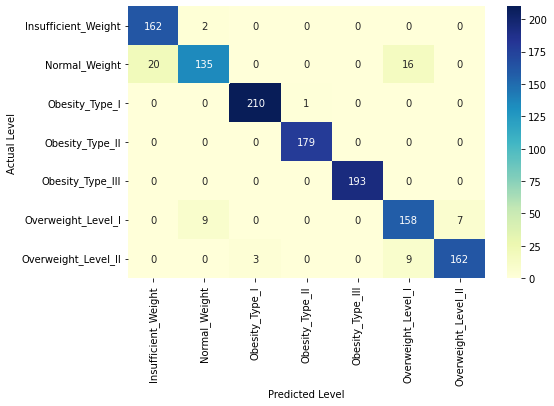

In [22]:
predict_model(X_train, dummy_Y_train)

22/22 [==============================] - 0s 2ms/step - loss: 0.3046 - accuracy: 0.9054 - precision: 0.9193 - recall: 0.8889 - aucroc: 0.9898
loss :  0.3046093285083771
accuracy :  0.9054373502731323
precision :  0.9193153977394104
recall :  0.8888888955116272
aucroc :  0.9898144006729126
              precision    recall  f1-score   support

           0      0.871     1.000     0.931        54
           1      0.911     0.707     0.796        58
           2      0.917     0.943     0.930        70
           3      0.983     0.983     0.983        60
           4      0.985     0.985     0.985        65
           5      0.761     0.879     0.816        58
           6      0.923     0.828     0.873        58

    accuracy                          0.905       423
   macro avg      0.907     0.904     0.902       423
weighted avg      0.910     0.905     0.904       423



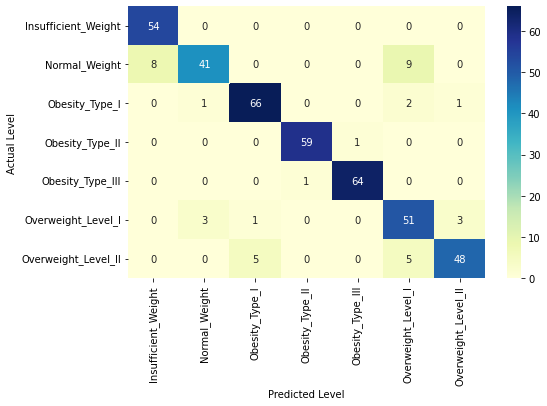

In [23]:
predict_model(X_test, dummy_Y_test)

In [45]:
for weight_set in obesity_model.get_weights():
  for item in weight_set:
    # if isinstance(item,(list,pandas.core.series.Series,np.ndarray)):
    #   for data in item:
    #     print(data)
    # else:
    print(item)
    # print("\n")
  print("\n\n")

[ 0.147455   -0.6670118  -0.28909674  0.03895409  0.3380881  -0.05371141
 -0.20343897 -0.2186936   0.13304062 -0.07615484 -0.08750723 -0.29501936
  0.07289903  0.3143177  -0.64869195 -0.26718724  0.08477349 -0.13692369
  0.3222141 ]
[ 0.37332758  0.19772264 -0.5595942  -0.21650541  0.22027886  0.20522678
  0.53571343  0.3544518   0.41863683  0.3097164  -0.26333094 -0.31445575
  0.35898343 -0.01123645  0.47786626  0.04707492 -0.5380342   0.01644352
 -0.63424635]
[-0.28130203  0.18289495 -0.392194   -0.4622134   0.2058164  -0.35337555
  0.6036384   0.38185135 -0.15380745  0.7365275  -0.2671996   0.13506447
  0.05996798 -0.28080067 -0.37682623  0.30464324  0.12118092 -0.434919
 -0.06448811]
[-0.35405457  0.46337166  1.0379637   0.63139385 -0.23835902  0.11049777
 -0.4621707  -0.9561461   1.2289375  -0.31502438  0.00661787 -1.1781662
  0.2746008   0.33216107  0.8607435  -0.8521626  -1.4496865  -0.3071962
  0.67955476]
[-0.44432053  0.02499738  0.0113874   0.34929085 -0.1176626  -0.39685404